# Assignment 2: AI - Ashna Desai, z5366651


## Imports and Initialising the Environment

In [183]:
# Assignment 2 - z5366651
import numpy as np
import pygame as pg
import matplotlib.pyplot as plt
import pandas as pd


from env import StaticGridEnv

from utils import plot_comparison_with_baseline

env = StaticGridEnv(seed = 42)

## Task 1 and 2: Agent Class

In [184]:
class Agent(object):
    def __init__(self, env):
        self.env = env
        # Boolean for if teacher is helping

        self.numOfActions = 4
        self.numOfStates = self.env.grid_size * self.env.grid_size
        self.Q = np.zeros((self.numOfStates, self.numOfActions))

        # Assigned learning rate, discount factor and epsilon action selection
        self.alpha = 0.7
        self.gamma = 0.4
        self.epsilon = 0.25

        # Track rewards for each episode
        self.cumulative_rewards = []
        # Track how many episodes were successful
        self.success_count = 0
        # Track how many steps were taken in each episode
        self.steps_per_episode = []

    def state_to_index(self, x, y):
        # Function that converts a state value (pair of x and y coordinates) to a single value
        return x * self.env.grid_size + y

    def index_to_state(self, index):
        # Function that converts a numerical state value to a state pair value
        x = index // self.env.grid_size
        y = index % self.env.grid_size
        return (x, y)

    def actionSelection(self, state):
        # Function that selects actions based on epsilon greedy approach
        if np.random.rand() <= self.epsilon:
            action = np.random.randint(self.numOfActions)
        else:
            action = np.argmax(self.Q[state, :])
        return action

    def train_q(self, iter):
        # reset reward, success and step count for each run
        self.cumulative_rewards.clear()
        self.success_count = 0
        self.steps_per_episode.clear()

        for itr in range(iter):
            start_x, start_y = self.env.reset()

            # store state as a single integer value
            state = self.state_to_index(start_x, start_y)

            # choose first action
            action = self.actionSelection(state)

            episode_reward = 0
            steps = 0
            episode = True

            while episode:
                # perform action
                (new_x, new_y), reward, done, info = self.env.step(action)
                state_new = self.state_to_index(new_x, new_y)

                # get next action
                action_new = self.actionSelection(state_new)

                # update q table with q learning algorithmn
                self.Q[state, action] += self.alpha * (
                    reward + self.gamma * self.Q[state_new, action_new] - self.Q[state, action]
                )

                # update reward and increment number of steps
                episode_reward += reward
                steps += 1

                # update state and action for next iteration
                state = state_new
                action = action_new

                # if goal found, increment success rate and stop episode
                if done:
                    episode = False
                    self.success_count += 1
                # if step count reaches 100 without finding goal, end episode
                if steps >= 100:
                    episode = False

            # store cumulative reward and steps for this episode
            self.cumulative_rewards.append(episode_reward)
            self.steps_per_episode.append(steps)

    def train_sarsa(self, iter):
        # clear
        self.cumulative_rewards.clear()
        self.success_count = 0
        self.steps_per_episode.clear()

        for _ in range(iter):
            start_x, start_y = self.env.reset()
            state = self.state_to_index(start_x, start_y)
            episode_reward = 0
            steps = 0
            done = False

            # Initial action
            action = self.actionSelection(state)

            while not done:
                (new_x, new_y), reward, done, info = self.env.step(action)
                state_new = self.state_to_index(new_x, new_y)

                # Choose next action for SARSA
                action_new = self.actionSelection(state_new)

                # SARSA update
                self.Q[state, action] += self.alpha * (
                    reward + self.gamma * self.Q[state_new, action_new] - self.Q[state, action]
                )

                episode_reward += reward
                steps += 1
                state = state_new
                action = action_new

                if done and reward > 0:
                    self.success_count += 1

                if steps >= 100:
                    done = True

            self.cumulative_rewards.append(episode_reward)
            self.steps_per_episode.append(steps)



    def plotCumulativeRewards(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.cumulative_rewards, label='Cumulative Reward')
        plt.xlabel("Episodes")
        plt.ylabel("Cumulative Reward")
        plt.title("Cumulative Reward vs Episodes")
        plt.legend()
        plt.show()

    def report_metrics(self):
        """Calculate and print the success rate, average reward, and learning speed."""
        total_episodes = len(self.cumulative_rewards)
        self.success_rate = (self.success_count / total_episodes) * 100
        self.avg_reward = np.mean(self.cumulative_rewards)
        self.avg_learning_speed = 1/np.mean(self.steps_per_episode)

        print("Agent Performance:")
        print(f"Average Reward per Episode: {self.avg_reward:.4f}")
        print(f"Success Rate: {self.success_rate:.4f}%")
        print(f"Average Learning Speed (steps to goal): {self.avg_learning_speed:.4f}")


## Task 2 and 3: Agent With Teacher Class

In [185]:
class AgentWithTeacher(Agent):
    def __init__(self, env, teacher_q_table):
        super().__init__(env)
        self.teacher_q_table = teacher_q_table
        self.results = pd.DataFrame(columns=['Availability', 'Accuracy','Avg Reward', 'Success Rate (%)', 'Avg Learning Speed'])

    def provideTeacherAdvice(self, state):
        random_value1 = np.random.rand()
        random_value2 = np.random.rand()

        # random chance based on availability
        if random_value1 < self.availability:
            # advice is provided, now check for accuracy
            if random_value2 < self.accuracy:
                # accurate advice
                correct_action = np.argmax(self.teacher_q_table[state, :])
                return correct_action
            else:
                # inaccurate advice
                correct_action = np.argmax(self.teacher_q_table[state, :])
                other_actions = [a for a in range(self.numOfActions) if a != correct_action]
                incorrect_action = np.random.choice(other_actions)
                return incorrect_action
        else:
            # No advice is provided
            return None

    def train_with_teacher_q(self, iter):
        # if agent has teacher advice, train with teacher
        self.results = pd.DataFrame(columns=['Availability', 'Accuracy', 'Avg Reward', 'Success Rate (%)', 'Avg Learning Speed'])
        for availability in [0.2, 0.4, 0.6, 0.8, 1.0]:
            for accuracy in [0.2, 0.4, 0.6, 0.8, 1.0]:

                # clear cumulative rewards, success count and steps per episode
                self.cumulative_rewards.clear()
                self.success_count = 0
                self.steps_per_episode.clear()

                self.availability = availability
                self.accuracy = accuracy

                # start training
                for _ in range(iter):
                    start_x, start_y = self.env.reset()
                    state = self.state_to_index(start_x, start_y)

                    # Choose initial action
                    action = self.provideTeacherAdvice(state)
                    if action is None:
                        action = self.actionSelection(state)

                    episode_reward = 0
                    steps = 0
                    episode = True

                    while episode:
                        # Perform action
                        (new_x, new_y), reward, done, info = self.env.step(action)
                        state_new = self.state_to_index(new_x, new_y)

                        # New action
                        action_new = self.provideTeacherAdvice(state_new)

                        if action_new is None:
                            action_new = self.actionSelection(state_new)

                        # update Q-values based on q learning algorithmn
                        self.Q[state, action] += self.alpha * (
                            reward + self.gamma * self.Q[state_new, action_new] - self.Q[state, action]
                        )

                        # add reward and increment step count
                        episode_reward += reward
                        steps += 1

                        state = state_new
                        action = action_new

                        if done:
                            episode = False
                            self.success_count += 1

                        if steps >= 100:
                            episode = False

                    self.cumulative_rewards.append(episode_reward)
                    self.steps_per_episode.append(steps)

                self.calculate_teacher_metrics()


    def train_with_teacher_sarsa(self, iter):
        # if agent has teacher advice, train with teacher
            self.results = pd.DataFrame(columns=['Availability', 'Accuracy','Avg Reward', 'Success Rate (%)', 'Avg Learning Speed'])
            for availability in [0.2, 0.4, 0.6, 0.8, 1.0]:
                for accuracy in [0.2, 0.4, 0.6, 0.8, 1.0]:

                    # clear cumulative rewards, success count and steps per episode
                    self.cumulative_rewards.clear()
                    self.success_count = 0
                    self.steps_per_episode.clear()

                    self.availability = availability
                    self.accuracy = accuracy

                    # start training
                    for _ in range(iter):
                        start_x, start_y = self.env.reset()
                        state = self.state_to_index(start_x, start_y)

                        # Choose initial action
                        action = self.provideTeacherAdvice(state)
                        if action is None:
                            action = self.actionSelection(state)

                        episode_reward = 0
                        steps = 0
                        episode = True

                        while episode:
                            # Perform action
                            (new_x, new_y), reward, done, info = self.env.step(action)
                            state_new = self.state_to_index(new_x, new_y)

                            # New action
                            action_new = self.provideTeacherAdvice(state_new)

                            if action_new is None:
                                action_new = self.actionSelection(state_new)

                            # update Q-values based on q learning algorithmn
                            self.Q[state, action] += self.alpha * (
                                reward + self.gamma * self.Q[state_new, action_new] - self.Q[state, action]
                            )

                            # add reward and increment step count
                            episode_reward += reward
                            steps += 1

                            state = state_new
                            action = action_new

                            if done:
                                episode = False
                                self.success_count += 1

                            if steps >= 100:
                                episode = False

                        self.cumulative_rewards.append(episode_reward)
                        self.steps_per_episode.append(steps)

                    self.calculate_teacher_metrics()


    def calculate_teacher_metrics(self):
        success_rate = (self.success_count / len(self.cumulative_rewards)) * 100  # Equation (1)
        average_reward = np.mean(self.cumulative_rewards)  # Equation (2)
        learning_speed = 1/np.mean(self.steps_per_episode)  # Equation (3)

        new_row = pd.DataFrame([{
            'Availability': self.availability,
            'Accuracy': self.accuracy,
            'Avg Reward': average_reward,
            'Success Rate (%)': success_rate,
            'Avg Learning Speed': learning_speed
        }])

        if self.results.empty:
            self.results = new_row
        else:
            # store new row in results df
            self.results = pd.concat([self.results, new_row], ignore_index=True)


    def plot_heatmap(self):
        # Reshape the data for heatmap plotting
        heatmap_data = self.results.pivot(index="Accuracy", columns="Availability", values="Avg Reward")

        # Plotting heatmap
        fig, ax = plt.subplots(figsize=(8, 6))
        cax = ax.matshow(heatmap_data, cmap=plt.cm.viridis_r)

        # Customize plot labels
        ax.set_xticks(range(len(availability_values)))
        ax.set_yticks(range(len(accuracy_values)))
        ax.set_xticklabels([f"{a:.2f}" for a in availability_values])
        ax.set_yticklabels([f"{a:.2f}" for a in accuracy_values])
        plt.xlabel("Availability")
        plt.ylabel("Accuracy")
        plt.title("Average Reward per Episode Heatmap")

        # Add color bar
        fig.colorbar(cax, ax=ax, label="Average Reward")

        plt.show()

## Reset The Environment

In [186]:

env = StaticGridEnv(seed = 42)
state = env.reset()


## Tasks to run

### Task 1


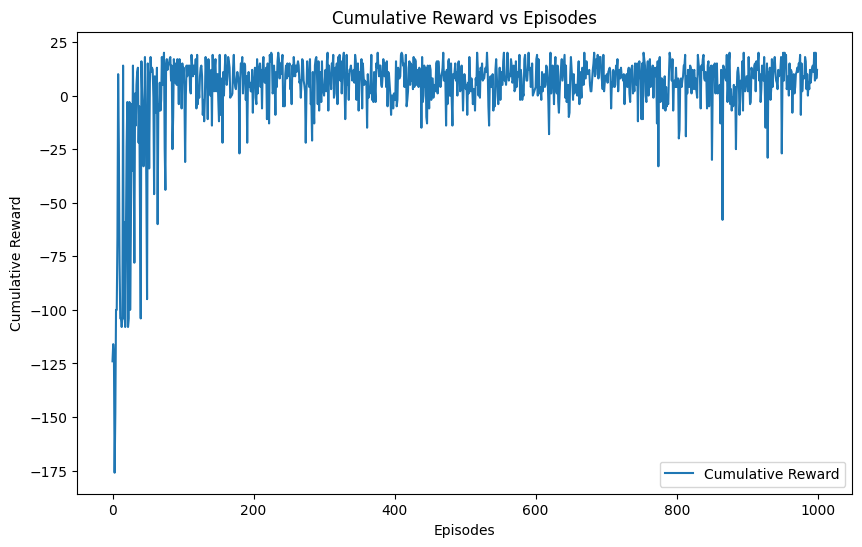

Agent Performance:
Average Reward per Episode: 3.8840
Success Rate: 98.3000%
Average Learning Speed (steps to goal): 0.0612


In [187]:

# initialise a learner
learner_q = Agent(env)
state = env.reset()

# train the learner using Q Learning
learner_q.train_q(1000)

# Plot the rewards and report the metrics
learner_q.plotCumulativeRewards()
learner_q.report_metrics()

# Save the data:
data = {
    'Metric': ['Average Reward', 'Success Rate', 'Average Learning Speed'],
    'Value': [ learner_q.avg_reward, learner_q.success_rate, learner_q.avg_learning_speed]
}
df = pd.DataFrame(data)
df.to_csv('task1_data.csv', index=False)


### Task 2

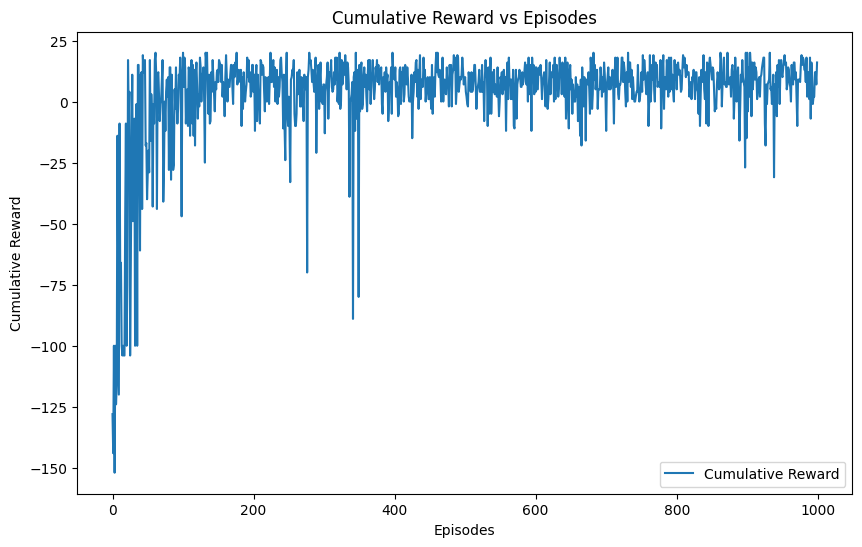

Agent Performance:
Average Reward per Episode: 3.6160
Success Rate: 98.3000%
Average Learning Speed (steps to goal): 0.0602


In [188]:
# initialise the agent and the environment
learner_s = Agent(env)
state = env.reset()

# train agent using sarsa
learner_s.train_sarsa(1000)

# create plot and report metrics
learner_s.plotCumulativeRewards()
learner_s.report_metrics()

# Save the data:
data = {
    'Metric': ['Average Reward', 'Success Rate', 'Average Learning Speed'],
    'Value': [ learner_s.avg_reward, learner_s.success_rate, learner_s.avg_learning_speed]
}
df = pd.DataFrame(data)
df.to_csv('task2_data.csv', index=False)


### Task 3

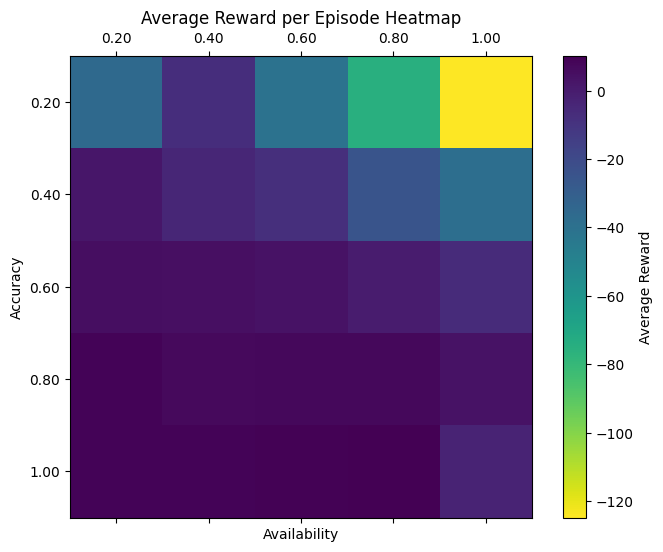

In [189]:

availability_values = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracy_values = [0.2, 0.4, 0.6, 0.8, 1.0]
episodes = 100

# Create agent with teacher advice
env = StaticGridEnv(seed=42)
teacher_q_table = learner_q.Q  # Use Q-table from previously trained agent
new_learner_q = AgentWithTeacher(env, teacher_q_table)
new_learner_q.train_with_teacher_q(episodes)

# Train and visualize results

new_learner_q.plot_heatmap()

new_learner_q.results.to_csv('task3_data.csv', index=False)

### Task 4

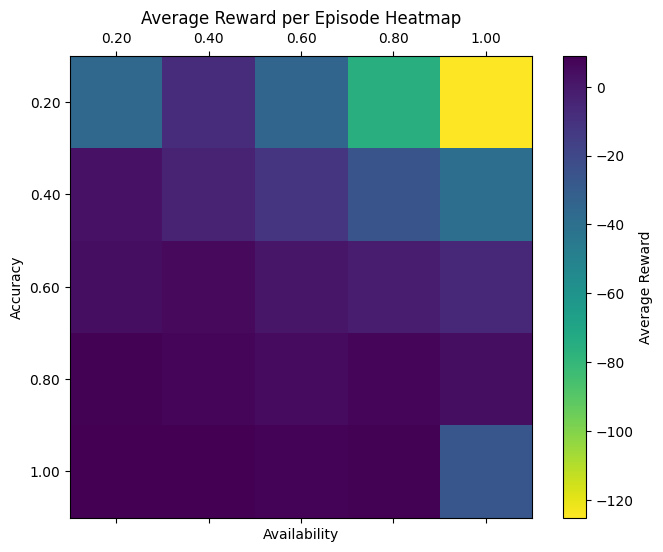

In [190]:

availability_values = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracy_values = [0.2, 0.4, 0.6, 0.8, 1.0]
episodes = 100

# Create agent with teacher advice
env = StaticGridEnv(seed=42)
teacher_s_table = learner_s.Q  # Use Q-table from previously trained agent
new_learner_s = AgentWithTeacher(env, teacher_s_table)
new_learner_s.train_with_teacher_sarsa(episodes)

# Train and visualize results

new_learner_s.plot_heatmap()

new_learner_s.results.to_csv('task4_data.csv', index=False)

## Plot Baseline

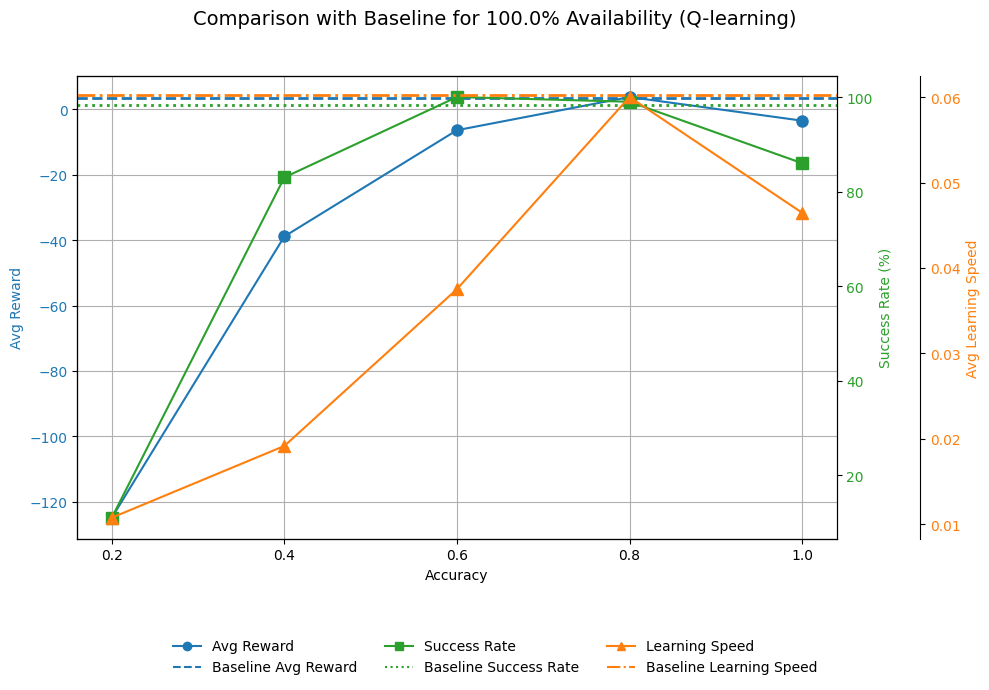

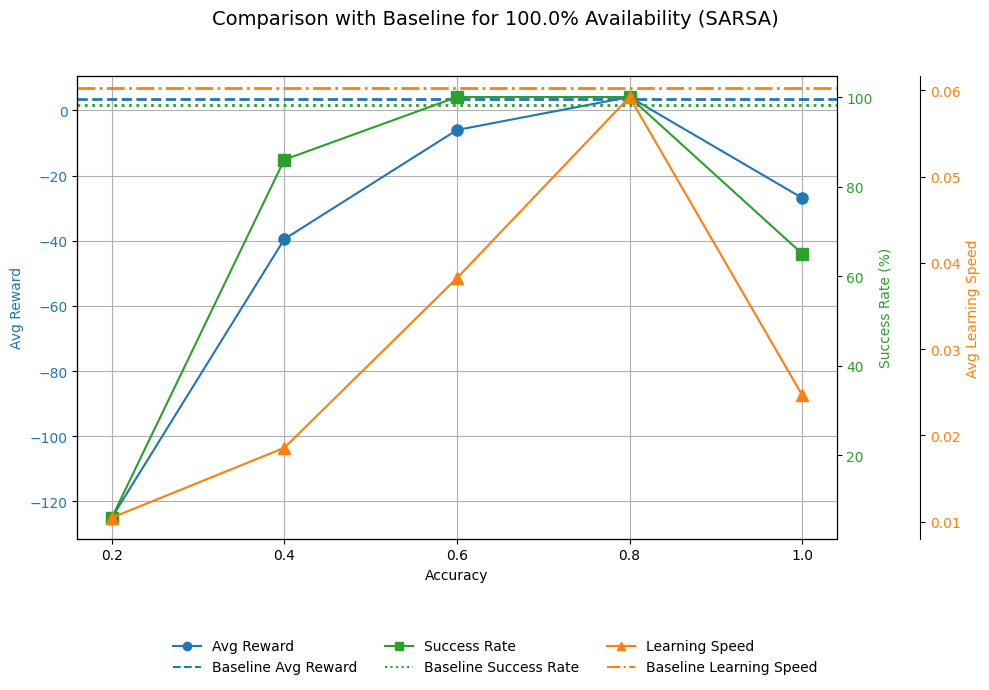

In [191]:

task_1_result = pd.read_csv('task1_data.csv')
task_2_result = pd.read_csv('task2_data.csv')
task_3_result = pd.read_csv('task3_data.csv')
task_4_result = pd.read_csv('task4_data.csv')

task_1_tuple= tuple(df['Value'].values)
task_2_tuple= tuple(df['Value'].values)

plot_comparison_with_baseline(
    availability=1.0,
    df_learning=task_3_result ,
    baseline_learning=task_1_tuple ,
    algorithm="Q-learning"
)
plot_comparison_with_baseline(
    availability=1.0,
    df_learning=task_4_result ,
    baseline_learning=task_2_tuple ,
    algorithm="SARSA"
)